In [1]:
#import
import pandas as pd
import numpy as np
import os
import random
import pickle
import scipy.io as sio
from scipy import stats
from general_function import *
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

C:\Users\bj\Anaconda2\envs\Python3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#mission
os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/')
first_part = listdir(contain='任务管理_管理员',file_type='.xlsx')
first_part = [i for i in first_part if '集合' not in i]
os.chdir('./OLD/')
second_part = listdir(contain='任务管理_管理员',file_type='.xlsx')
second_part = [i for i in second_part if '集合' not in i]
full_filename = sorted(list(set(first_part+second_part)))

In [3]:
#data
os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/')
adjfactor = pd.read_csv('adjfactor.csv',index_col=0)
adjfactor.columns = adjfactor.columns.astype(int)
volume = pd.read_csv('volume.csv',index_col=0)
volume.columns = volume.columns.astype(int)
volume = volume.reindex(columns = adjfactor.columns)
amt = pd.read_csv('amt.csv',index_col=0)
amt.columns = amt.columns.astype(int)
amt = amt.reindex(columns = adjfactor.columns)
open_p = pd.read_csv('open.csv',index_col=0)
open_p.columns = open_p.columns.astype(int)
open_p = open_p.reindex(columns = adjfactor.columns)
close = pd.read_csv('close.csv',index_col=0)
close.columns = close.columns.astype(int)
close = close.reindex(columns = adjfactor.columns)
high = pd.read_csv('high.csv',index_col=0)
high.columns = high.columns.astype(int)
high = high.reindex(columns = adjfactor.columns)
low = pd.read_csv('low.csv',index_col=0)
low.columns = low.columns.astype(int)
low = low.reindex(columns = adjfactor.columns)
ohlc_sigma_c = pd.read_csv('ohlc_sigma_c.csv',index_col=0)
ohlc_sigma_c.columns = ohlc_sigma_c.columns.astype(int)
free_float_shares = pd.read_csv('free_float_shares.csv',index_col=0)
free_float_shares.columns = free_float_shares.columns.astype(int)
mkt_cap_ard = pd.read_csv('mkt_cap_ard.csv',index_col=0)
mkt_cap_ard.columns = mkt_cap_ard.columns.astype(int)
adjusted_preclose = (close * adjfactor / adjfactor.shift(-1)).shift(1)
stop_profit_mid = open_p.copy()
stop_profit_mid[stop_profit_mid<adjusted_preclose*1.07] = adjusted_preclose*1.07
stop_profit_close = close.copy()
stop_profit_close[(high / adjusted_preclose)>1.07] = stop_profit_mid

In [2]:
os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/minutes_data/')

In [64]:
data = pd.read_pickle('SH600053.pkl')
data['date'] = data['datetime'].str[:10].str.replace('-','').astype(int)
data['time'] = data['datetime'].str[-8:-3].str.replace(':','').astype(int)
data[['收盘价','开盘价','最高价','最低价']] = data[['收盘价','开盘价','最高价','最低价']].replace(0,np.nan)
data.dropna(inplace = True)
data[['成交量','成交金额']] = data[['成交量','成交金额']].astype(float)

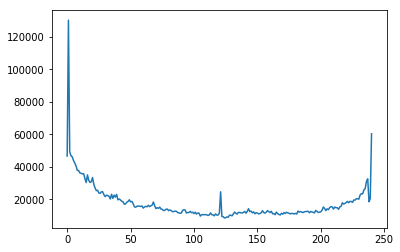

In [65]:
days = 1000
end = 20190625
sub_data = data[data['date'].isin(np.sort(data['date'][data['date']<end].unique())[-days:])]
plt.plot(sub_data.groupby('time').mean()['成交量'].tolist())
plt.show()

array([20190125, 20190128, 20190129, 20190130, 20190131], dtype=int64)

full_sell = pd.DataFrame()
full_buy = pd.DataFrame()
for filename in full_filename:
    date = int(filename[11:-5].replace('-',''))
    try:
        os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/')
        data = pd.read_excel(filename)
    except:
        os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/OLD/')
        data = pd.read_excel(filename)
    if date not in open_p.index.tolist():
        continue
    data = data[data['完成股数']>=100]
    data = data[data['完成资金']>=100]
    data = data.groupby(['股票代码','方向']).sum().reset_index()
    data['date'] = date
    try:
        os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/')
        data['open_amt'] = pd.read_csv('open_amt_'+str(date)+'.csv',encoding='gbk',index_col=0)['开盘金额'].loc[data['股票代码']].tolist()
    except:
        os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/OLD/')
        data['open_amt'] = pd.read_csv('open_amt_'+str(date)+'.csv',encoding='gbk',index_col=0)['开盘金额'].loc[data['股票代码']].tolist()
    data['open'] = open_p.xs(date).loc[data['股票代码']].tolist()
    data['open_volume'] = data['open_amt']/data['open']
    data['preclose'] = adjusted_preclose.xs(date).loc[data['股票代码']].tolist()
    data['close'] = close.xs(date).loc[data['股票代码']].tolist()
    data['stop_profit_close'] = stop_profit_close.xs(date).loc[data['股票代码']].tolist()
    data['low'] = low.xs(date).loc[data['股票代码']].tolist()
    data['high'] = high.xs(date).loc[data['股票代码']].tolist()
    data['volume'] = volume.xs(date).loc[data['股票代码']].tolist()
    data['amt'] = amt.xs(date).loc[data['股票代码']].tolist()
    data['mkt_cap_ard'] = mkt_cap_ard.xs(date).loc[data['股票代码']].tolist()
    data['ohlc_sigma_c'] = ohlc_sigma_c.xs(date).loc[data['股票代码']].tolist()
    data['free_float_shares'] = free_float_shares.xs(date).loc[data['股票代码']].tolist()
    data['average'] = data['amt']/data['volume']
    data['real'] = data['完成资金']/data['完成股数']
    data = data[data['real']>data['low']]
    data = data[data['real']<data['high']]
    data = data[data['volume']!=0]
    data = data[data['amt']!=0]
    sell = data[data['方向']=='空']
    buy = data[data['方向']=='多']
    full_sell = pd.concat([full_sell,sell])
    full_buy = pd.concat([full_buy,buy])

full_sell = full_sell.reset_index(drop=True)
full_buy = full_buy.reset_index(drop=True)
full_sell = full_sell[((full_sell['real']/full_sell['average'] - 1)<0.2) & ((full_sell['real']/full_sell['average'] - 1)>-0.2)]
full_buy = full_buy[((full_buy['real']/full_buy['average'] - 1)<0.2) & ((full_buy['real']/full_buy['average'] - 1)>-0.2)]
full_sell = full_sell.sort_values('完成资金')
full_buy = full_buy.sort_values('完成资金')

full_buy.set_index(['date','股票代码'],inplace = True)
full_sell.set_index(['date','股票代码'],inplace = True)

full_sell = full_sell[full_sell['完成资金']>1000000]
full_buy = full_buy[full_buy['完成资金']>1000000]

plt.hist(full_sell['real']/full_sell['average'] - 1, bins = 100,density=True,alpha = 0.5)
plt.hist(full_sell['real']/full_sell['stop_profit_close'] - 1, bins = 100,density=True,alpha = 0.5)
plt.show()
plt.hist(full_buy['real']/full_buy['average'] - 1, bins = 100,density=True,alpha = 0.5)
plt.hist(full_buy['real']/full_buy['open'] - 1, bins = 100,density=True,alpha = 0.5)
plt.show()

def emp_permanent_part(variables, X, V, theta, sigma, T):
    gamma, alpha, delta, c = variables
    return (gamma * T * ((X / (V * T)) ** alpha) * ((theta / V) ** delta) * sigma + c).dropna()
def emp_permanent_part_result(variables, X, V, theta, sigma, T, y):
    return (emp_permanent_part(variables, X = X, V = V, theta = theta, sigma = sigma, T = T) - y).dropna()

n_part = 1
for i in range(n_part):
    if i == 0:
        sub_full_sell = full_sell.iloc[:int(len(full_sell)/n_part*(i+1))]
    elif i == n_part-1:
        sub_full_sell = full_sell.iloc[int(len(full_sell)/n_part*i):]
    else:
        sub_full_sell = full_sell.iloc[int(len(full_sell)/n_part*i):int(len(full_sell)/n_part*(i+1))]
    x0 = [1,1,-1,0]
    T = 0.1
    result = least_squares(emp_permanent_part_result,x0,jac = '3-point',\
        args=(sub_full_sell['完成股数'],sub_full_sell['volume'],sub_full_sell['free_float_shares'],\
        sub_full_sell['ohlc_sigma_c'],T,sub_full_sell['average']/sub_full_sell['real']-1))
    fitted_result = emp_permanent_part(result.x,sub_full_sell['完成股数'],sub_full_sell['volume'],\
        sub_full_sell['free_float_shares'],sub_full_sell['ohlc_sigma_c'],T)
    real_result = sub_full_sell['average']/sub_full_sell['real']-1
    fitted_result = ((fitted_result - fitted_result.mean()) / fitted_result.std() * real_result.std() + real_result.mean())
    print(OLS(real_result,fitted_result).fit().summary())
    plt.figure(figsize = (6,6))
    plt.plot(fitted_result.tolist(),real_result.tolist(),'.',alpha=0.05)
    plt.title(i)
    plt.plot([-0.1,0.1],[-0.1,0.1])
    plt.xlim(-0.15,0.15)
    plt.ylim(-0.15,0.15)
    plt.show()

plt.figure(figsize = (16,3))
plt.plot(real_result.iloc[:200].tolist(),label = 'real',alpha = 0.5)
plt.plot(fitted_result.iloc[:200].tolist(),label = 'fit',alpha = 0.5)
plt.legend()
plt.show()

pd.concat([real_result,fitted_result],axis=1).mean()

def emp_permanent_part(variables, X, m_V, V, theta, sigma, T):
    gamma, alpha, delta, c = variables
    return (gamma * (((X - m_V) / (V * T)) ** alpha) * ((theta / V) ** delta) * sigma + c).dropna()
def emp_permanent_part_result(variables, X, m_V, V, theta, sigma, T, y):
    return (emp_permanent_part(variables, X = X, m_V = m_V, V = V, theta = theta, sigma = sigma, T = T) - y).dropna()

n_part = 1
for i in range(n_part):
    if i == 0:
        sub_full_buy = full_buy.iloc[:int(len(full_buy)/n_part*(i+1))]
    elif i == n_part-1:
        sub_full_buy = full_buy.iloc[int(len(full_buy)/n_part*i):]
    else:
        sub_full_buy = full_buy.iloc[int(len(full_buy)/n_part*i):int(len(full_buy)/n_part*(i+1))]
    sub_full_buy = sub_full_buy[sub_full_buy['完成股数']/sub_full_buy['open_volume']>0.5]
    x0 = [1,1,-1,0]
    T = 1
    result = least_squares(emp_permanent_part_result,x0,jac = '3-point',\
        args=(sub_full_buy['完成股数'],0.5*sub_full_buy['open_volume'],sub_full_buy['volume'],sub_full_buy['free_float_shares'],\
        sub_full_buy['ohlc_sigma_c'],T,sub_full_buy['real']/sub_full_buy['average']-1))
    fitted_result = emp_permanent_part(result.x,sub_full_buy['完成股数'],0.5*sub_full_buy['open_volume'],sub_full_buy['volume'],\
        sub_full_buy['free_float_shares'],sub_full_buy['ohlc_sigma_c'],T)
    real_result = sub_full_buy['real']/sub_full_buy['average']-1
    fitted_result = ((fitted_result - fitted_result.mean()) / fitted_result.std() * real_result.std() + real_result.mean())
    print(OLS(real_result,fitted_result).fit().summary())
    plt.figure(figsize = (6,6))
    plt.plot(fitted_result.tolist(),real_result.tolist(),'.',alpha=0.05)
    plt.title(i)
    plt.plot([-0.05,0.05],[-0.05,0.05])
    plt.xlim(-0.1,0.1)
    plt.ylim(-0.1,0.1)
    plt.show()

plt.figure(figsize = (16,3))
plt.plot(real_result.iloc[200:400].tolist(),label = 'real',alpha = 0.5)
plt.plot(fitted_result.iloc[200:400].tolist(),label = 'fit',alpha = 0.5)
plt.legend()
plt.show()

pd.concat([real_result,fitted_result],axis=1).mean()

In [18]:
full_sell = pd.DataFrame()
full_buy = pd.DataFrame()
for filename in full_filename:
    date = int(filename[11:-5].replace('-',''))
    if date>20190522:
        continue
    try:
        os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/')
        data = pd.read_excel(filename)
    except:
        os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/OLD/')
        data = pd.read_excel(filename)
    if date not in open_p.index.tolist():
        continue
    data = data[data['完成股数']>=100]
    data = data[data['完成资金']>=100]
    data = data.groupby(['股票代码','方向']).sum().reset_index()
    data['date'] = date
    try:
        os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/')
        data['open_amt'] = pd.read_csv('open_amt_'+str(date)+'.csv',encoding='gbk',index_col=0)['开盘金额'].loc[data['股票代码']].tolist()
    except:
        os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/OLD/')
        data['open_amt'] = pd.read_csv('open_amt_'+str(date)+'.csv',encoding='gbk',index_col=0)['开盘金额'].loc[data['股票代码']].tolist()
    data['open'] = open_p.xs(date).loc[data['股票代码']].tolist()
    data['open_volume'] = data['open_amt']/data['open']
    data['preclose'] = adjusted_preclose.xs(date).loc[data['股票代码']].tolist()
    data['close'] = close.xs(date).loc[data['股票代码']].tolist()
    data['stop_profit_close'] = stop_profit_close.xs(date).loc[data['股票代码']].tolist()
    data['low'] = low.xs(date).loc[data['股票代码']].tolist()
    data['high'] = high.xs(date).loc[data['股票代码']].tolist()
    data['volume'] = volume.xs(date).loc[data['股票代码']].tolist()
    data['amt'] = amt.xs(date).loc[data['股票代码']].tolist()
    data['mkt_cap_ard'] = mkt_cap_ard.xs(date).loc[data['股票代码']].tolist()
    data['ohlc_sigma_c'] = ohlc_sigma_c.xs(date).loc[data['股票代码']].tolist()
    data['free_float_shares'] = free_float_shares.xs(date).loc[data['股票代码']].tolist()
    data['average'] = data['amt']/data['volume']
    data['real'] = data['完成资金']/data['完成股数']
    data = data[data['real']>data['low']]
    data = data[data['real']<data['high']]
    data = data[data['volume']!=0]
    data = data[data['amt']!=0]
    sell = data[data['方向']=='空']
    buy = data[data['方向']=='多']
    full_sell = pd.concat([full_sell,sell])
    full_buy = pd.concat([full_buy,buy])
full_sell = full_sell.reset_index(drop=True)
full_buy = full_buy.reset_index(drop=True)
full_sell = full_sell[((full_sell['real']/full_sell['average'] - 1)<0.2) & ((full_sell['real']/full_sell['average'] - 1)>-0.2)]
full_buy = full_buy[((full_buy['real']/full_buy['average'] - 1)<0.2) & ((full_buy['real']/full_buy['average'] - 1)>-0.2)]
full_buy['股票代码'] = full_buy['股票代码'].astype(int)
full_sell['股票代码'] = full_sell['股票代码'].astype(int)

In [ ]:
os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/分钟数据/')
new_full_buy = pd.DataFrame()
participation_ratio_list = [0.01,0.05,0.1,0.2,0.3,0.4,0.5]
for stock_code in full_buy['股票代码'].unique():
#for stock_code in np.random.choice(full_buy['股票代码'].unique(),100):
#for stock_code in [600819]:
    print(stock_code)
    sub_full_buy = full_buy[full_buy['股票代码'] == stock_code]
    minutes_data = pd.DataFrame(sio.loadmat('0' * (6 - len(str(stock_code))) + str(stock_code) + '.mat')['data1'])
    minutes_data[[3,4,5,6]] = minutes_data[[3,4,5,6]].replace(0,np.nan)
    minutes_data.dropna(inplace = True)
    minutes_data[[7,8]] = minutes_data.groupby(1).cumsum()[[7,8]]
    TWAP_list = []; VWAP_list = []; volume_list = []; sigma_list = []; diff_list = []
    for i in sub_full_buy.index:
        sub_TWAP_list = []; sub_VWAP_list = []; sub_volume_list = []; sub_sigma_list = []; sub_diff_list = []
        stock_date = sub_full_buy.xs(i)['date']
        if stock_date not in minutes_data[1].tolist():
            for participation_ratio in participation_ratio_list:
                sub_TWAP_list.append(np.nan)
                sub_VWAP_list.append(np.nan)
                sub_volume_list.append(np.nan)
                sub_sigma_list.append(np.nan)
                sub_diff_list.append(np.nan)
            TWAP_list.append(sub_TWAP_list)
            VWAP_list.append(sub_VWAP_list)
            volume_list.append(sub_volume_list)
            sigma_list.append(sub_sigma_list)
            diff_list.append(sub_diff_list)
            continue
        sub_minutes_data = minutes_data[minutes_data[1] == stock_date]
        for participation_ratio in participation_ratio_list:
            needed_amt = sub_full_buy.xs(i)['完成资金'] / participation_ratio
            try:
                modified_sub_minutes_data = pd.concat([sub_minutes_data[sub_minutes_data[8]<needed_amt],\
                                          sub_minutes_data[sub_minutes_data[8]>needed_amt].iloc[[0]]])
            except:
                modified_sub_minutes_data = sub_minutes_data.copy()
            sub_TWAP_list.append(modified_sub_minutes_data[6].mean())
            sub_VWAP_list.append(modified_sub_minutes_data.iloc[-1][8]/modified_sub_minutes_data.iloc[-1][7])
            sub_volume_list.append(modified_sub_minutes_data.iloc[-1][7])
            sub_sigma_list.append(modified_sub_minutes_data[6].diff().std())
            sub_diff_list.append((modified_sub_minutes_data.iloc[-1,6] - modified_sub_minutes_data.iloc[0,3])/modified_sub_minutes_data.iloc[0,3])
        TWAP_list.append(sub_TWAP_list)
        VWAP_list.append(sub_VWAP_list)
        volume_list.append(sub_volume_list)
        sigma_list.append(sub_sigma_list)
        diff_list.append(sub_diff_list)
    sub_full_buy = pd.concat([sub_full_buy,\
        pd.DataFrame(TWAP_list,index = sub_full_buy.index, columns = [str(name)+'TWAP' for name in participation_ratio_list]),\
        pd.DataFrame(VWAP_list,index = sub_full_buy.index, columns = [str(name)+'VWAP' for name in participation_ratio_list]),\
        pd.DataFrame(volume_list,index = sub_full_buy.index, columns = [str(name)+'volume' for name in participation_ratio_list]),\
        pd.DataFrame(sigma_list,index = sub_full_buy.index, columns = [str(name)+'sigma' for name in participation_ratio_list]),\
        pd.DataFrame(diff_list,index = sub_full_buy.index, columns = [str(name)+'diff' for name in participation_ratio_list]),\
                             ],axis=1)
    new_full_buy = pd.concat([new_full_buy,sub_full_buy])
    new_full_buy.to_pickle('new_full_buy_with_sigma_diff.pkl')

In [4]:
os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/分钟数据/')
new_full_buy = pd.read_pickle('new_full_buy_with_sigma_diff.pkl')

In [5]:
print('ave',calc_stat(new_full_buy['real']/new_full_buy['average'] - 1))
print('open',calc_stat(new_full_buy['real']/new_full_buy['open'] - 1))
print('0.01V',calc_stat(new_full_buy['real']/new_full_buy['0.01VWAP'] - 1))
print('0.01V',calc_stat(new_full_buy['real']/new_full_buy['0.01TWAP'] - 1))
print('0.05V',calc_stat(new_full_buy['real']/new_full_buy['0.05VWAP'] - 1))
print('0.05V',calc_stat(new_full_buy['real']/new_full_buy['0.05TWAP'] - 1))
print('0.1V',calc_stat(new_full_buy['real']/new_full_buy['0.1VWAP'] - 1))
print('0.1T',calc_stat(new_full_buy['real']/new_full_buy['0.1TWAP'] - 1))
print('0.2V',calc_stat(new_full_buy['real']/new_full_buy['0.2VWAP'] - 1))
print('0.2T',calc_stat(new_full_buy['real']/new_full_buy['0.2TWAP'] - 1))
print('0.3V',calc_stat(new_full_buy['real']/new_full_buy['0.3VWAP'] - 1))
print('0.3T',calc_stat(new_full_buy['real']/new_full_buy['0.3TWAP'] - 1))
print('0.4V',calc_stat(new_full_buy['real']/new_full_buy['0.4VWAP'] - 1))
print('0.4T',calc_stat(new_full_buy['real']/new_full_buy['0.4TWAP'] - 1))
print('0.5V',calc_stat(new_full_buy['real']/new_full_buy['0.5VWAP'] - 1))
print('0.5T',calc_stat(new_full_buy['real']/new_full_buy['0.5TWAP'] - 1))

ave [-0.001059736021648089, 0.018020429315747186, -0.2758653819219297, 2.708383264312614]
open [0.0025637578829897194, 0.00931635065340065, 1.8842303233483444, 15.113285670566054]
0.01V [0.0001642688755531249, 0.012115080484435652, -0.21363679647865882, 6.314989950178328]
0.01V [0.0004994525377021722, 0.012226439885987523, -0.232034690773465, 7.64441551636191]
0.05V [0.0008049825215044618, 0.008196233152201624, 0.6359910729176839, 18.306243055060353]
0.05V [0.001108248391939733, 0.008307733142162854, 0.892843255998648, 19.53118216289613]
0.1V [0.0009548015220529575, 0.007179318848989572, 1.4671514906336067, 29.819516817328193]
0.1T [0.0012289224566563797, 0.007339701416281347, 1.6012067287504328, 30.336555252848207]
0.2V [0.0010649481457044136, 0.007102290064705312, 2.050280414928013, 33.55709328403718]
0.2T [0.0013244157627043155, 0.0071911669974223085, 2.1574555579140586, 34.17080158800722]
0.3V [0.0011790396209637854, 0.007327736374242553, 2.1442365474578273, 30.962949541378066]
0.3

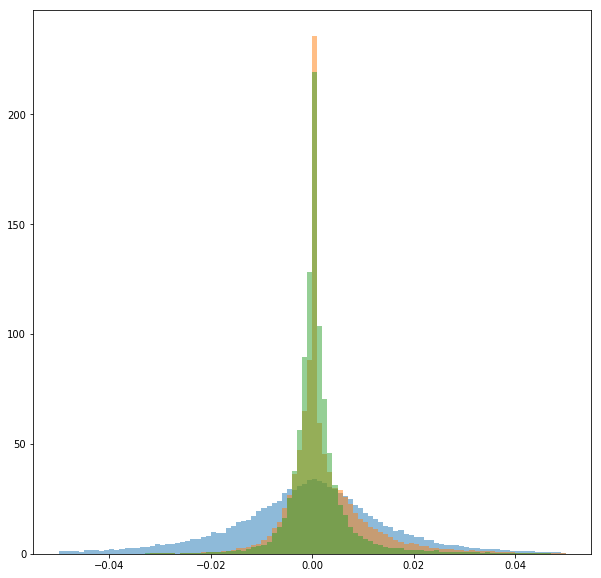

In [6]:
plt.figure(figsize = (10,10))
plt.hist(new_full_buy['real']/new_full_buy['average'] - 1, bins = 100, range = (-0.05, 0.05), density = True, alpha = 0.5)
plt.hist(new_full_buy['real']/new_full_buy['open'] - 1, bins = 100, range = (-0.05, 0.05), density = True, alpha = 0.5)
plt.hist(new_full_buy['real']/new_full_buy['0.2VWAP'] - 1, bins = 100, range = (-0.05, 0.05), density = True, alpha = 0.5)
plt.show()

In [7]:
new_full_buy['完成股数/open_volume'] = new_full_buy['完成股数']/new_full_buy['open_volume']
new_full_buy['open_volume/free_float_shares'] = new_full_buy['open_volume']/new_full_buy['free_float_shares']
new_full_buy['volume/free_float_shares'] = new_full_buy['volume']/new_full_buy['free_float_shares']
new_full_buy['0.05volume/free_float_shares'] = new_full_buy['0.05volume']/new_full_buy['free_float_shares']
new_full_buy['0.1volume/free_float_shares'] = new_full_buy['0.1volume']/new_full_buy['free_float_shares']
new_full_buy['0.2volume/free_float_shares'] = new_full_buy['0.2volume']/new_full_buy['free_float_shares']
new_full_buy['0.3volume/free_float_shares'] = new_full_buy['0.3volume']/new_full_buy['free_float_shares']
new_full_buy['0.4volume/free_float_shares'] = new_full_buy['0.4volume']/new_full_buy['free_float_shares']
new_full_buy['0.5volume/free_float_shares'] = new_full_buy['0.5volume']/new_full_buy['free_float_shares']

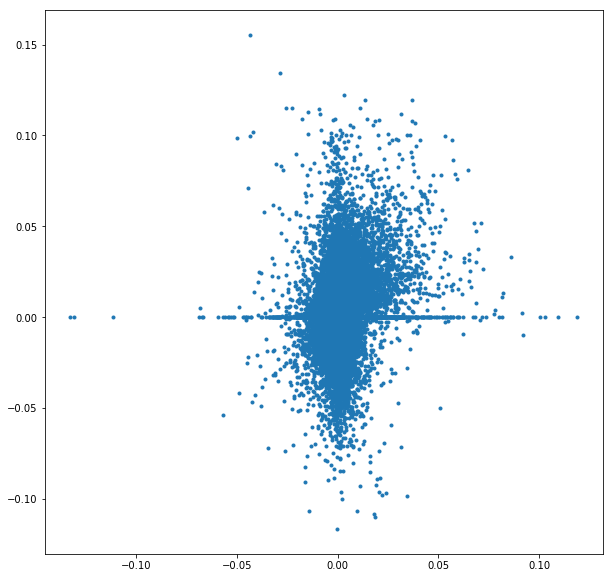

In [8]:
plt.figure(figsize = (10,10))
plt.plot(new_full_buy['real']/new_full_buy['0.2VWAP'] - 1,new_full_buy['0.05diff'],'.')
plt.show()

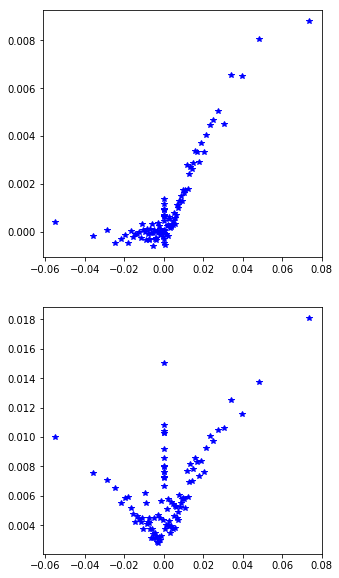

In [9]:
n = 100
fig = plt.figure(figsize = (5,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
buy_side_x = []
buy_side_y = []
for i in range(n):
    if new_full_buy.sort_values('0.05diff')\
             .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.05diff'].mean()<99:
        ax1.plot(new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.05diff'].mean(),\
                 calc_stat(new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['real']/\
                 new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.2VWAP'] - 1)[0],'b*')
        ax2.plot(new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.05diff'].mean(),\
                 calc_stat(new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['real']/\
                 new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.2VWAP'] - 1)[1],'b*')
        buy_side_x.append(new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.05diff'].mean())
        buy_side_y.append(calc_stat(new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['real']/\
                 new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.2VWAP'] - 1)[0])
plt.show()

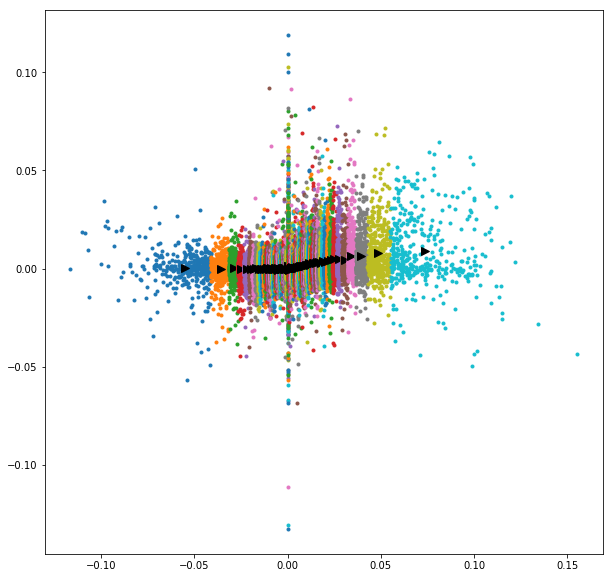

In [10]:
n = 100
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
for i in range(n):
    if new_full_buy.sort_values('0.05diff')\
             .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.05diff'].mean()<99:
        ax1.plot(new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.05diff'],\
                 new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['real']/\
                 new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.2VWAP'] - 1,'.')
        ax1.plot(new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.05diff'].mean(),\
                 calc_stat(new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['real']/\
                 new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_buy)):int((i+1)/n*len(new_full_buy))+1]['0.2VWAP'] - 1)[0],'k>',ms=7.5)
plt.show()

In [25]:
os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/分钟数据/')
new_full_sell = pd.DataFrame()
participation_ratio_list = [0.01,0.05,0.1,0.2,0.3,0.4,0.5]
for stock_code in full_sell['股票代码'].unique():
#for stock_code in np.random.choice(full_sell['股票代码'].unique(),20):
    print(stock_code)
    sub_full_sell = full_sell[full_sell['股票代码'] == stock_code]
    minutes_data = pd.DataFrame(sio.loadmat('0' * (6 - len(str(stock_code))) + str(stock_code) + '.mat')['data1']).sort_index(ascending=False)
    minutes_data[[3,4,5,6]] = minutes_data[[3,4,5,6]].replace(0,np.nan)
    minutes_data.dropna(inplace = True)
    minutes_data[[7,8]] = minutes_data.groupby(1).cumsum()[[7,8]]
    TWAP_list = []; VWAP_list = []; volume_list = []; sigma_list = []; diff_list = []
    for i in sub_full_sell.index:
        sub_TWAP_list = []; sub_VWAP_list = []; sub_volume_list = []; sub_sigma_list = []; sub_diff_list = []
        stock_date = sub_full_sell.xs(i)['date']
        if stock_date not in minutes_data[1].tolist():
            for participation_ratio in participation_ratio_list:
                sub_TWAP_list.append(np.nan)
                sub_VWAP_list.append(np.nan)
                sub_volume_list.append(np.nan)
                sub_sigma_list.append(np.nan)
                sub_diff_list.append(np.nan)
            TWAP_list.append(sub_TWAP_list)
            VWAP_list.append(sub_VWAP_list)
            volume_list.append(sub_volume_list)
            sigma_list.append(sub_sigma_list)
            diff_list.append(sub_diff_list)
            continue
        sub_minutes_data = minutes_data[minutes_data[1] == stock_date]
        for participation_ratio in participation_ratio_list:
            needed_amt = sub_full_sell.xs(i)['完成资金'] / participation_ratio
            try:
                modified_sub_minutes_data = pd.concat([sub_minutes_data[sub_minutes_data[8]<needed_amt],\
                                          sub_minutes_data[sub_minutes_data[8]>needed_amt].iloc[[0]]])
            except:
                modified_sub_minutes_data = sub_minutes_data.copy()
            sub_TWAP_list.append(modified_sub_minutes_data[6].mean())
            sub_VWAP_list.append(modified_sub_minutes_data.iloc[-1][8]/modified_sub_minutes_data.iloc[-1][7])
            sub_volume_list.append(modified_sub_minutes_data.iloc[-1][7])
            sub_sigma_list.append(modified_sub_minutes_data[6].diff().std())
            sub_diff_list.append((modified_sub_minutes_data.iloc[0,6] - modified_sub_minutes_data.iloc[-1,3])/modified_sub_minutes_data.iloc[-1,3])
        TWAP_list.append(sub_TWAP_list)
        VWAP_list.append(sub_VWAP_list)
        volume_list.append(sub_volume_list)
        sigma_list.append(sub_sigma_list)
        diff_list.append(sub_diff_list)
    sub_full_sell = pd.concat([sub_full_sell,\
        pd.DataFrame(TWAP_list,index = sub_full_sell.index, columns = [str(name)+'TWAP' for name in participation_ratio_list]),\
        pd.DataFrame(VWAP_list,index = sub_full_sell.index, columns = [str(name)+'VWAP' for name in participation_ratio_list]),\
        pd.DataFrame(volume_list,index = sub_full_sell.index, columns = [str(name)+'volume' for name in participation_ratio_list]),\
        pd.DataFrame(sigma_list,index = sub_full_sell.index, columns = [str(name)+'sigma' for name in participation_ratio_list]),\
        pd.DataFrame(diff_list,index = sub_full_sell.index, columns = [str(name)+'diff' for name in participation_ratio_list]),\
                             ],axis=1).dropna()
    new_full_sell = pd.concat([new_full_sell,sub_full_sell])
    new_full_sell.to_pickle('new_full_sell_with_sigma_diff.pkl')

16
21
36
49
155
157
333
402
430
506
521
523
531
536
543
544
557
558
564
566
572
582
586
596
601
607
625
668
670
687
695
702
712
713
715
716
721
739
798
809
815
823
860
876
882
886
905
920
933
948
950
955
957
960
987
1896
2011
2019
2040
2041
2050
2054
2056
2073
2077
2081
2082
2086
2087
2089
2091
2098
2103
2104
2114
2115
2139
2140
2144
2149
2159
2164
2170
2175
2178
2185
2200
2213
2219
2220
2226
2234
2235
2250
2270
2284
2285
2286
2288
2291
2292
2296
2299
2314
2325
2329
2332
2357
2363
2400
2404
2408
2428
2429
2433
2435
2436
2446
2467
2494
2499
2501
2519
2538
2555
2563
2568
2569
2577
2581
2583
2588
2589
2596
2607
2614
2616
2619
2622
2637
2638
2652
2660
2676
2677
2684
2687
2691
2722
2741
2746
2748
2760
2762
2770
2778
2792
2803
2805
2810
2848
2850
2856
2885
2891
2913
2916
2925
2928
2929
2932
300001
300002
300004
300008
300014
300030
300045
300051
300054
300064
300071
300082
300089
300109
300110
300111
300118
300135
300141
300157
300175
300208
300221
300235
300238
300241
300254
300257
300273
3

2189
2307
2347
2382
2414
2639
2675
2705
2728
2935
300013
300059
300150
300173
300280
300289
300381
300385
300604
300715
300718
300735
600132
600167
600429
600493
600495
600687
600760
600782
600805
601006
601100
601158
601601
601669
601800
603101
603160
603214
603345
603500
603520
603588
603680
603939
629
662
729
963
2016
2023
2262
2305
2308
2370
2477
2507
2557
2618
2733
2751
300011
300136
300596
300611
600054
600276
600377
600463
600466
600489
600500
600525
600528
600728
600780
600895
601002
601211
601231
601390
601636
601965
603039
603360
603378
603383
603398
603658
603688
603701
603711
603778
603859
603903
603933
4
151
420
429
524
733
799
932
966
2100
2238
2383
2508
2859
2883
300180
300312
300344
300398
300447
300551
300680
300700
600033
600068
600085
600239
600317
600467
600693
600827
600828
600846
600908
601222
601318
601718
601992
603106
603128
603269
603320
603506
603665
498
517
656
778
899
2025
2047
2090
2165
2223
2256
2394
2546
2679
2860
2905
2927
300126
300342
300461
600242
60

600083
600651
600719
603167
26
2026
2183
2401
300039
300191
600018
600587
603178
603316
603685
2236
2331
2340
2373
2815
2827
300056
300137
300143
300476
300507
600111
600201
600295
600686
601336
2279
300112
300204
300324
300416
300501
300729
600039
600060
600066
600605
600858
603648
603779
65
504
756
2053
2731
300278
300328
300417
300712
600338
603311
603977
540
705
766
985
2301
2397
2524
300430
300676
600284
600375
600550
600603
601311
510
757
790
2349
2355
2460
2672
2911
300084
300492
600129
600368
603568
2388
2864
300151
300219
300298
300358
300434
300500
300535
300737
600008
600288
601116
603031
603359
603978
635
930
2241
2303
2476
300227
300232
300244
600058
600582
600823
600894
601567
603188
301
410
519
2432
2587
2602
300380
300411
300428
600635
627
680
819
2915
300117
300379
300525
300675
300717
300761
600278
600581
600836
603825
603919
2495
2631
2702
2896
300103
300582
300720
600527
600796
600959
603655
603676
603690
603809
637
2312
300177
300509
601577
603222
603669
603966
231

In [26]:
os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/分钟数据/')
new_full_sell = pd.read_pickle('new_full_sell_with_sigma_diff.pkl')

In [27]:
print('ave',calc_stat(new_full_sell['real']/new_full_sell['average'] - 1))
print('stop_profit_close',calc_stat(new_full_sell['real']/new_full_sell['stop_profit_close'] - 1))
print('close',calc_stat(new_full_sell['real']/new_full_sell['close'] - 1))
print('0.05V',calc_stat(new_full_sell['real']/new_full_sell['0.05VWAP'] - 1))
print('0.05T',calc_stat(new_full_sell['real']/new_full_sell['0.05TWAP'] - 1))
print('0.1V',calc_stat(new_full_sell['real']/new_full_sell['0.1VWAP'] - 1))
print('0.1T',calc_stat(new_full_sell['real']/new_full_sell['0.1TWAP'] - 1))
print('0.2V',calc_stat(new_full_sell['real']/new_full_sell['0.2VWAP'] - 1))
print('0.2T',calc_stat(new_full_sell['real']/new_full_sell['0.2TWAP'] - 1))
print('0.3V',calc_stat(new_full_sell['real']/new_full_sell['0.3VWAP'] - 1))
print('0.3T',calc_stat(new_full_sell['real']/new_full_sell['0.3TWAP'] - 1))
print('0.4V',calc_stat(new_full_sell['real']/new_full_sell['0.4VWAP'] - 1))
print('0.4T',calc_stat(new_full_sell['real']/new_full_sell['0.4TWAP'] - 1))
print('0.5V',calc_stat(new_full_sell['real']/new_full_sell['0.5VWAP'] - 1))
print('0.5T',calc_stat(new_full_sell['real']/new_full_sell['0.5TWAP'] - 1))

ave [-0.0023424535842382615, 0.010055787867992598, 0.1174483408834971, 4.4564437602106555]
stop_profit_close [-0.0008041242470646902, 0.008456502235209946, -0.9138446635654027, 15.495584642842957]
close [-0.0010416618906241126, 0.010477265024196346, 0.8520648113127232, 18.16432052781103]
0.05V [-0.001980958995793499, 0.009310203134097816, 0.5076233975548767, 18.917204502715574]
0.05T [-0.002264764748846085, 0.009585827601929976, 0.20176474072222292, 15.543516543266595]
0.1V [-0.0013588987566011158, 0.009557048715651108, 0.8655975548893078, 23.248007993103485]
0.1T [-0.0016785993923569944, 0.009636924175381414, 0.7198408480260627, 21.748899239262702]
0.2V [-0.000894883033245128, 0.009867891185086493, 0.8653659010334739, 21.647004116452678]
0.2T [-0.0011982477995287487, 0.009869014845500238, 0.8596525481841675, 21.398880274968615]
0.3V [-0.0007541803345109481, 0.010043088296883197, 0.8838562367828634, 21.317942257532742]
0.3T [-0.0010330347628095882, 0.01001515418643015, 0.91390694557811

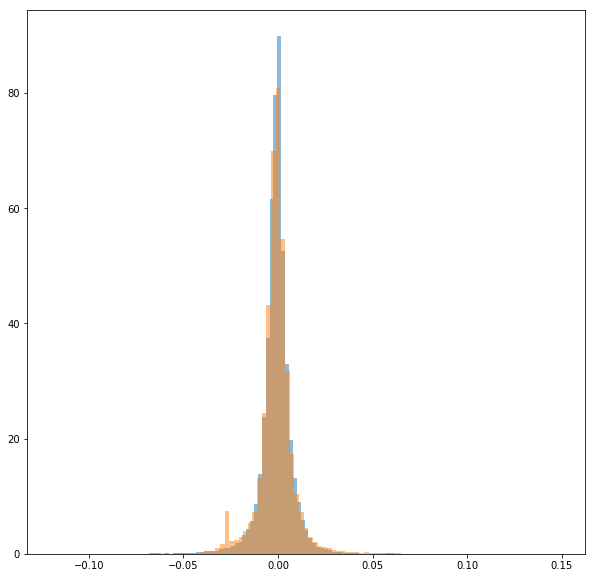

In [28]:
plt.figure(figsize = (10,10))
#plt.hist(new_full_sell['real']/new_full_sell['average'] - 1, bins = 100,density=True,alpha = 0.5)
plt.hist(new_full_sell['real']/new_full_sell['stop_profit_close'] - 1, bins = 100,density=True,alpha = 0.5)
plt.hist(new_full_sell['real']/new_full_sell['close'] - 1, bins = 100,density=True,alpha = 0.5)
#plt.hist(new_full_sell['real']/new_full_sell['0.05VWAP'] - 1, bins = 100,density=True,alpha = 0.5)
plt.show()

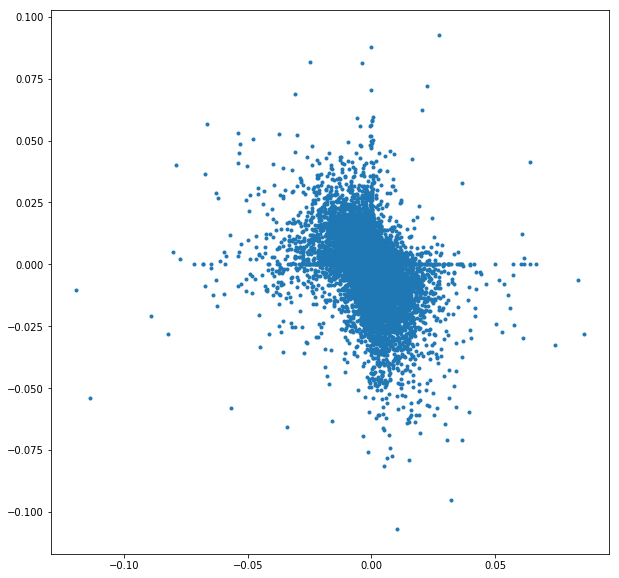

In [38]:
plt.figure(figsize = (10,10))
plt.plot(new_full_sell['real']/new_full_sell['stop_profit_close'] - 1,new_full_sell['0.1diff'],'.')
plt.show()

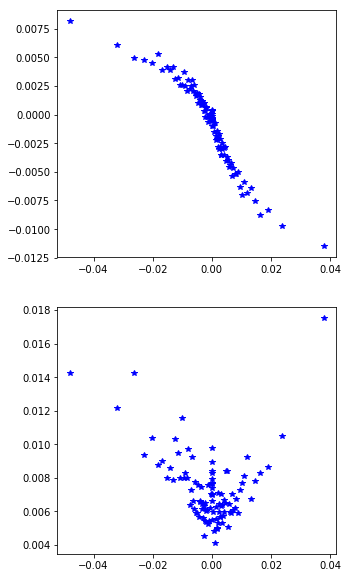

In [39]:
n = 100
fig = plt.figure(figsize = (5,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sell_side_x = []
sell_side_y = []
for i in range(n):
    if new_full_sell.sort_values('0.1diff')\
             .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['0.1diff'].mean()<99:
        ax1.plot(new_full_sell.sort_values('0.1diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['0.1diff'].mean(),\
                 calc_stat(new_full_sell.sort_values('0.1diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['real']/\
                 new_full_sell.sort_values('0.1diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['stop_profit_close'] - 1)[0],'b*')
        ax2.plot(new_full_sell.sort_values('0.1diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['0.1diff'].mean(),\
                 calc_stat(new_full_sell.sort_values('0.1diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['real']/\
                 new_full_sell.sort_values('0.1diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['stop_profit_close'] - 1)[1],'b*')
        sell_side_x.append(new_full_sell.sort_values('0.1diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['0.1diff'].mean())
        sell_side_y.append(calc_stat(new_full_sell.sort_values('0.1diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['real']/\
                 new_full_sell.sort_values('0.1diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['stop_profit_close'] - 1)[0])
plt.show()

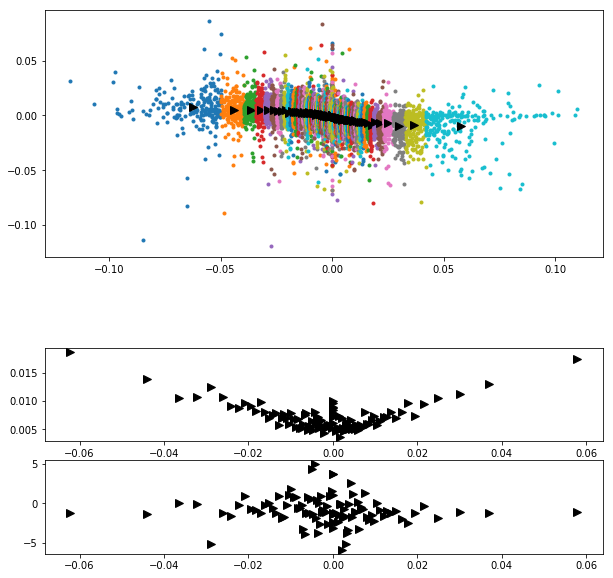

In [54]:
n = 100
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(514)
ax3 = fig.add_subplot(515)
for i in range(n):
    if new_full_sell.sort_values('0.05diff')\
             .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['0.05diff'].mean()<99:
        ax1.plot(new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['0.05diff'],\
                 new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['real']/\
                 new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['stop_profit_close'] - 1,'.')
        ax1.plot(new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['0.05diff'].mean(),\
                 calc_stat(new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['real']/\
                 new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['stop_profit_close'] - 1)[0],'k>',ms=7.5)
        ax2.plot(new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['0.05diff'].mean(),\
                 calc_stat(new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['real']/\
                 new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['stop_profit_close'] - 1)[1],'k>',ms=7.5)
        ax3.plot(new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['0.05diff'].mean(),\
                 calc_stat(new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['real']/\
                 new_full_sell.sort_values('0.05diff')\
                 .iloc[int(i/n*len(new_full_sell)):int((i+1)/n*len(new_full_sell))+1]['stop_profit_close'] - 1)[2],'k>',ms=7.5)
plt.show()

In [ ]:
buy_side_x = np.array(buy_side_x)
buy_side_y = np.array(buy_side_y)
buy_side_x_nega_part = buy_side_x[buy_side_x<0]
buy_side_x_posi_part = buy_side_x[buy_side_x>=0]
buy_side_y_nega_part = buy_side_y[buy_side_x<0]
buy_side_y_posi_part = buy_side_y[buy_side_x>=0]
sell_side_x = np.array(sell_side_x)
sell_side_y = np.array(sell_side_y)

In [ ]:
buy_side_X_nega_part = np.column_stack((buy_side_x_nega_part, ))
buy_side_X_nega_part = sm.add_constant(buy_side_X_nega_part)
olsmod = sm.OLS(buy_side_y_nega_part, buy_side_X_nega_part)
olsres = olsmod.fit()
buy_side_y_nega_part_pred = olsres.predict(buy_side_X_nega_part)
print(olsres.summary())
fig, ax = plt.subplots()
ax.plot(buy_side_x_nega_part, buy_side_y_nega_part, 'o', label="Data")
ax.plot(buy_side_x_nega_part, buy_side_y_nega_part_pred, 'r', label="OLS prediction")
ax.legend(loc="best")
plt.show()

In [ ]:
buy_side_X_posi_part = np.column_stack((buy_side_x_posi_part, buy_side_x_posi_part**2,))
#buy_side_X_posi_part = sm.add_constant(buy_side_X_posi_part)
olsmod = sm.OLS(buy_side_y_posi_part, buy_side_X_posi_part)
olsres = olsmod.fit()
buy_side_y_posi_part_pred = olsres.predict(buy_side_X_posi_part)
print(olsres.summary())
fig, ax = plt.subplots()
ax.plot(buy_side_x_posi_part, buy_side_y_posi_part, 'o', label="Data")
ax.plot(buy_side_x_posi_part, buy_side_y_posi_part_pred, 'r', label="OLS prediction")
ax.legend(loc="best")
plt.show()

In [ ]:
sell_side_X = np.column_stack((sell_side_x**2,))
sell_side_X = sm.add_constant(sell_side_X)
olsmod = sm.OLS(sell_side_y, sell_side_X)
olsres = olsmod.fit()
sell_side_y_pred = olsres.predict(sell_side_X)
print(olsres.summary())
fig, ax = plt.subplots()
ax.plot(sell_side_x, sell_side_y, 'o', label="Data")
ax.plot(sell_side_x, sell_side_y_pred, 'r', label="OLS prediction")
ax.legend(loc="best")
plt.show()

In [ ]:
start_date = 20181101
end_date = 20190601
sub_new_full_buy = new_full_buy[(new_full_buy['date']>=start_date) & (new_full_buy['date']<end_date)]
sub_new_full_sell = new_full_sell[(new_full_sell['date']>=start_date) & (new_full_sell['date']<end_date)]
n = 100
if True:
    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_buy_side_x = []
    sub_buy_side_y = []
    for i in range(n):
        if sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean()<99:
            ax1.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0],'b*')
            ax2.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[1],'b*')
            sub_buy_side_x.append(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean())
            sub_buy_side_y.append(calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0])
    ax1.set_title('buy side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/0.2VWAP - 1) mean')
    ax1.set_xlabel('0.05 diff')
    ax2.set_title('buy side cost std')
    ax2.set_ylabel('(real/0.2VWAP - 1) std')
    ax2.set_xlabel('0.05 diff')
    plt.show()

    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_sell_side_x = []
    sub_sell_side_y = []
    for i in range(n):
        if sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean()<99:
            ax1.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0],'b*')
            ax2.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[1],'b*')
            sub_sell_side_x.append(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean())
            sub_sell_side_y.append(calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0])
    ax1.set_title('sell side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/stop-profit-close - 1) mean')
    ax1.set_xlabel('ohlc_sigma')
    ax2.set_title('sell side cost std')
    ax2.set_ylabel('(real/stop-profit-close - 1) std')
    ax2.set_xlabel('ohlc_sigma')
    plt.show()
if True:
    sub_buy_side_x = np.array(sub_buy_side_x)
    sub_buy_side_y = np.array(sub_buy_side_y)
    sub_buy_side_x_nega_part = sub_buy_side_x[sub_buy_side_x<0]
    sub_buy_side_x_posi_part = sub_buy_side_x[sub_buy_side_x>=0]
    sub_buy_side_y_nega_part = sub_buy_side_y[sub_buy_side_x<0]
    sub_buy_side_y_posi_part = sub_buy_side_y[sub_buy_side_x>=0]
    
    sub_buy_side_X_nega_part = np.column_stack((sub_buy_side_x_nega_part, ))
    sub_buy_side_X_nega_part = sm.add_constant(sub_buy_side_X_nega_part)
    olsmod = sm.OLS(sub_buy_side_y_nega_part, sub_buy_side_X_nega_part)
    olsres = olsmod.fit()
    sub_buy_side_y_nega_part_pred = olsres.predict(sub_buy_side_X_nega_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    sub_buy_side_X_posi_part = np.column_stack((sub_buy_side_x_posi_part, sub_buy_side_x_posi_part**2))
    #sub_buy_side_X_posi_part = sm.add_constant(sub_buy_side_X_posi_part)
    olsmod = sm.OLS(sub_buy_side_y_posi_part, sub_buy_side_X_posi_part)
    olsres = olsmod.fit()
    sub_buy_side_y_posi_part_pred = olsres.predict(sub_buy_side_X_posi_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    
    sub_sell_side_x = np.array(sub_sell_side_x)
    sub_sell_side_y = np.array(sub_sell_side_y)
    
    sub_sell_side_X = np.column_stack((sub_sell_side_x**2,))
    sub_sell_side_X = sm.add_constant(sub_sell_side_X)
    olsmod = sm.OLS(sub_sell_side_y, sub_sell_side_X)
    olsres = olsmod.fit()
    sub_sell_side_y_pred = olsres.predict(sub_sell_side_X)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_sell_side_x, sub_sell_side_y, 'o', label="Data")
    ax.plot(sub_sell_side_x, sub_sell_side_y_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()

In [ ]:
start_date = 20181101
end_date = 20190101
sub_new_full_buy = new_full_buy[(new_full_buy['date']>=start_date) & (new_full_buy['date']<end_date)]
sub_new_full_sell = new_full_sell[(new_full_sell['date']>=start_date) & (new_full_sell['date']<end_date)]
n = 100
if True:
    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_buy_side_x = []
    sub_buy_side_y = []
    for i in range(n):
        if sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean()<99:
            ax1.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0],'b*')
            ax2.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[1],'b*')
            sub_buy_side_x.append(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean())
            sub_buy_side_y.append(calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0])
    ax1.set_title('buy side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/0.2VWAP - 1) mean')
    ax1.set_xlabel('0.05 diff')
    ax2.set_title('buy side cost std')
    ax2.set_ylabel('(real/0.2VWAP - 1) std')
    ax2.set_xlabel('0.05 diff')
    plt.show()

    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_sell_side_x = []
    sub_sell_side_y = []
    for i in range(n):
        if sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean()<99:
            ax1.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0],'b*')
            ax2.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[1],'b*')
            sub_sell_side_x.append(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean())
            sub_sell_side_y.append(calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0])
    ax1.set_title('sell side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/stop-profit-close - 1) mean')
    ax1.set_xlabel('ohlc_sigma')
    ax2.set_title('sell side cost std')
    ax2.set_ylabel('(real/stop-profit-close - 1) std')
    ax2.set_xlabel('ohlc_sigma')
    plt.show()
if True:
    sub_buy_side_x = np.array(sub_buy_side_x)
    sub_buy_side_y = np.array(sub_buy_side_y)
    sub_buy_side_x_nega_part = sub_buy_side_x[sub_buy_side_x<0]
    sub_buy_side_x_posi_part = sub_buy_side_x[sub_buy_side_x>=0]
    sub_buy_side_y_nega_part = sub_buy_side_y[sub_buy_side_x<0]
    sub_buy_side_y_posi_part = sub_buy_side_y[sub_buy_side_x>=0]
    
    sub_buy_side_X_nega_part = np.column_stack((sub_buy_side_x_nega_part, ))
    sub_buy_side_X_nega_part = sm.add_constant(sub_buy_side_X_nega_part)
    olsmod = sm.OLS(sub_buy_side_y_nega_part, sub_buy_side_X_nega_part)
    olsres = olsmod.fit()
    sub_buy_side_y_nega_part_pred = olsres.predict(sub_buy_side_X_nega_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    sub_buy_side_X_posi_part = np.column_stack((sub_buy_side_x_posi_part, sub_buy_side_x_posi_part**2))
    #sub_buy_side_X_posi_part = sm.add_constant(sub_buy_side_X_posi_part)
    olsmod = sm.OLS(sub_buy_side_y_posi_part, sub_buy_side_X_posi_part)
    olsres = olsmod.fit()
    sub_buy_side_y_posi_part_pred = olsres.predict(sub_buy_side_X_posi_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    
    sub_sell_side_x = np.array(sub_sell_side_x)
    sub_sell_side_y = np.array(sub_sell_side_y)
    
    sub_sell_side_X = np.column_stack((sub_sell_side_x**2,))
    sub_sell_side_X = sm.add_constant(sub_sell_side_X)
    olsmod = sm.OLS(sub_sell_side_y, sub_sell_side_X)
    olsres = olsmod.fit()
    sub_sell_side_y_pred = olsres.predict(sub_sell_side_X)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_sell_side_x, sub_sell_side_y, 'o', label="Data")
    ax.plot(sub_sell_side_x, sub_sell_side_y_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()

In [ ]:
start_date = 20190101
end_date = 20190301
sub_new_full_buy = new_full_buy[(new_full_buy['date']>=start_date) & (new_full_buy['date']<end_date)]
sub_new_full_sell = new_full_sell[(new_full_sell['date']>=start_date) & (new_full_sell['date']<end_date)]
n = 100
if True:
    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_buy_side_x = []
    sub_buy_side_y = []
    for i in range(n):
        if sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean()<99:
            ax1.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0],'b*')
            ax2.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[1],'b*')
            sub_buy_side_x.append(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean())
            sub_buy_side_y.append(calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0])
    ax1.set_title('buy side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/0.2VWAP - 1) mean')
    ax1.set_xlabel('0.05 diff')
    ax2.set_title('buy side cost std')
    ax2.set_ylabel('(real/0.2VWAP - 1) std')
    ax2.set_xlabel('0.05 diff')
    plt.show()

    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_sell_side_x = []
    sub_sell_side_y = []
    for i in range(n):
        if sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean()<99:
            ax1.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0],'b*')
            ax2.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[1],'b*')
            sub_sell_side_x.append(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean())
            sub_sell_side_y.append(calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0])
    ax1.set_title('sell side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/stop-profit-close - 1) mean')
    ax1.set_xlabel('ohlc_sigma')
    ax2.set_title('sell side cost std')
    ax2.set_ylabel('(real/stop-profit-close - 1) std')
    ax2.set_xlabel('ohlc_sigma')
    plt.show()
if True:
    sub_buy_side_x = np.array(sub_buy_side_x)
    sub_buy_side_y = np.array(sub_buy_side_y)
    sub_buy_side_x_nega_part = sub_buy_side_x[sub_buy_side_x<0]
    sub_buy_side_x_posi_part = sub_buy_side_x[sub_buy_side_x>=0]
    sub_buy_side_y_nega_part = sub_buy_side_y[sub_buy_side_x<0]
    sub_buy_side_y_posi_part = sub_buy_side_y[sub_buy_side_x>=0]
    
    sub_buy_side_X_nega_part = np.column_stack((sub_buy_side_x_nega_part, ))
    sub_buy_side_X_nega_part = sm.add_constant(sub_buy_side_X_nega_part)
    olsmod = sm.OLS(sub_buy_side_y_nega_part, sub_buy_side_X_nega_part)
    olsres = olsmod.fit()
    sub_buy_side_y_nega_part_pred = olsres.predict(sub_buy_side_X_nega_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    sub_buy_side_X_posi_part = np.column_stack((sub_buy_side_x_posi_part, sub_buy_side_x_posi_part**2))
    #sub_buy_side_X_posi_part = sm.add_constant(sub_buy_side_X_posi_part)
    olsmod = sm.OLS(sub_buy_side_y_posi_part, sub_buy_side_X_posi_part)
    olsres = olsmod.fit()
    sub_buy_side_y_posi_part_pred = olsres.predict(sub_buy_side_X_posi_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    
    sub_sell_side_x = np.array(sub_sell_side_x)
    sub_sell_side_y = np.array(sub_sell_side_y)
    
    sub_sell_side_X = np.column_stack((sub_sell_side_x**2,))
    sub_sell_side_X = sm.add_constant(sub_sell_side_X)
    olsmod = sm.OLS(sub_sell_side_y, sub_sell_side_X)
    olsres = olsmod.fit()
    sub_sell_side_y_pred = olsres.predict(sub_sell_side_X)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_sell_side_x, sub_sell_side_y, 'o', label="Data")
    ax.plot(sub_sell_side_x, sub_sell_side_y_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()

In [ ]:
start_date = 20190301
end_date = 20190501
sub_new_full_buy = new_full_buy[(new_full_buy['date']>=start_date) & (new_full_buy['date']<end_date)]
sub_new_full_sell = new_full_sell[(new_full_sell['date']>=start_date) & (new_full_sell['date']<end_date)]
n = 100
if True:
    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_buy_side_x = []
    sub_buy_side_y = []
    for i in range(n):
        if sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean()<99:
            ax1.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0],'b*')
            ax2.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[1],'b*')
            sub_buy_side_x.append(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean())
            sub_buy_side_y.append(calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0])
    ax1.set_title('buy side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/0.2VWAP - 1) mean')
    ax1.set_xlabel('0.05 diff')
    ax2.set_title('buy side cost std')
    ax2.set_ylabel('(real/0.2VWAP - 1) std')
    ax2.set_xlabel('0.05 diff')
    plt.show()

    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_sell_side_x = []
    sub_sell_side_y = []
    for i in range(n):
        if sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean()<99:
            ax1.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0],'b*')
            ax2.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[1],'b*')
            sub_sell_side_x.append(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean())
            sub_sell_side_y.append(calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0])
    ax1.set_title('sell side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/stop-profit-close - 1) mean')
    ax1.set_xlabel('ohlc_sigma')
    ax2.set_title('sell side cost std')
    ax2.set_ylabel('(real/stop-profit-close - 1) std')
    ax2.set_xlabel('ohlc_sigma')
    plt.show()
if True:
    sub_buy_side_x = np.array(sub_buy_side_x)
    sub_buy_side_y = np.array(sub_buy_side_y)
    sub_buy_side_x_nega_part = sub_buy_side_x[sub_buy_side_x<0]
    sub_buy_side_x_posi_part = sub_buy_side_x[sub_buy_side_x>=0]
    sub_buy_side_y_nega_part = sub_buy_side_y[sub_buy_side_x<0]
    sub_buy_side_y_posi_part = sub_buy_side_y[sub_buy_side_x>=0]
    
    sub_buy_side_X_nega_part = np.column_stack((sub_buy_side_x_nega_part, ))
    sub_buy_side_X_nega_part = sm.add_constant(sub_buy_side_X_nega_part)
    olsmod = sm.OLS(sub_buy_side_y_nega_part, sub_buy_side_X_nega_part)
    olsres = olsmod.fit()
    sub_buy_side_y_nega_part_pred = olsres.predict(sub_buy_side_X_nega_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    sub_buy_side_X_posi_part = np.column_stack((sub_buy_side_x_posi_part, sub_buy_side_x_posi_part**2))
    #sub_buy_side_X_posi_part = sm.add_constant(sub_buy_side_X_posi_part)
    olsmod = sm.OLS(sub_buy_side_y_posi_part, sub_buy_side_X_posi_part)
    olsres = olsmod.fit()
    sub_buy_side_y_posi_part_pred = olsres.predict(sub_buy_side_X_posi_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    
    sub_sell_side_x = np.array(sub_sell_side_x)
    sub_sell_side_y = np.array(sub_sell_side_y)
    
    sub_sell_side_X = np.column_stack((sub_sell_side_x**2,))
    sub_sell_side_X = sm.add_constant(sub_sell_side_X)
    olsmod = sm.OLS(sub_sell_side_y, sub_sell_side_X)
    olsres = olsmod.fit()
    sub_sell_side_y_pred = olsres.predict(sub_sell_side_X)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_sell_side_x, sub_sell_side_y, 'o', label="Data")
    ax.plot(sub_sell_side_x, sub_sell_side_y_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()

In [ ]:
start_date = 20190401
end_date = 20190601
sub_new_full_buy = new_full_buy[(new_full_buy['date']>=start_date) & (new_full_buy['date']<end_date)]
sub_new_full_sell = new_full_sell[(new_full_sell['date']>=start_date) & (new_full_sell['date']<end_date)]
n = 100
if True:
    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_buy_side_x = []
    sub_buy_side_y = []
    for i in range(n):
        if sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean()<99:
            ax1.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0],'b*')
            ax2.plot(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                     calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[1],'b*')
            sub_buy_side_x.append(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean())
            sub_buy_side_y.append(calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                     sub_new_full_buy.sort_values('0.05diff')\
                     .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0])
    ax1.set_title('buy side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/0.2VWAP - 1) mean')
    ax1.set_xlabel('0.05 diff')
    ax2.set_title('buy side cost std')
    ax2.set_ylabel('(real/0.2VWAP - 1) std')
    ax2.set_xlabel('0.05 diff')
    plt.show()

    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    sub_sell_side_x = []
    sub_sell_side_y = []
    for i in range(n):
        if sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean()<99:
            ax1.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0],'b*')
            ax2.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                     calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[1],'b*')
            sub_sell_side_x.append(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean())
            sub_sell_side_y.append(calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                     sub_new_full_sell.sort_values('ohlc_sigma_c')\
                     .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0])
    ax1.set_title('sell side cost mean '+str(start_date)+'~'+str(end_date))
    ax1.set_ylabel('(real/stop-profit-close - 1) mean')
    ax1.set_xlabel('ohlc_sigma')
    ax2.set_title('sell side cost std')
    ax2.set_ylabel('(real/stop-profit-close - 1) std')
    ax2.set_xlabel('ohlc_sigma')
    plt.show()
if True:
    sub_buy_side_x = np.array(sub_buy_side_x)
    sub_buy_side_y = np.array(sub_buy_side_y)
    sub_buy_side_x_nega_part = sub_buy_side_x[sub_buy_side_x<0]
    sub_buy_side_x_posi_part = sub_buy_side_x[sub_buy_side_x>=0]
    sub_buy_side_y_nega_part = sub_buy_side_y[sub_buy_side_x<0]
    sub_buy_side_y_posi_part = sub_buy_side_y[sub_buy_side_x>=0]
    
    sub_buy_side_X_nega_part = np.column_stack((sub_buy_side_x_nega_part, ))
    sub_buy_side_X_nega_part = sm.add_constant(sub_buy_side_X_nega_part)
    olsmod = sm.OLS(sub_buy_side_y_nega_part, sub_buy_side_X_nega_part)
    olsres = olsmod.fit()
    sub_buy_side_y_nega_part_pred = olsres.predict(sub_buy_side_X_nega_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_nega_part, sub_buy_side_y_nega_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    sub_buy_side_X_posi_part = np.column_stack((sub_buy_side_x_posi_part, sub_buy_side_x_posi_part**2))
    #sub_buy_side_X_posi_part = sm.add_constant(sub_buy_side_X_posi_part)
    olsmod = sm.OLS(sub_buy_side_y_posi_part, sub_buy_side_X_posi_part)
    olsres = olsmod.fit()
    sub_buy_side_y_posi_part_pred = olsres.predict(sub_buy_side_X_posi_part)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part, 'o', label="Data")
    ax.plot(sub_buy_side_x_posi_part, sub_buy_side_y_posi_part_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()
    
    sub_sell_side_x = np.array(sub_sell_side_x)
    sub_sell_side_y = np.array(sub_sell_side_y)
    
    sub_sell_side_X = np.column_stack((sub_sell_side_x**2,))
    sub_sell_side_X = sm.add_constant(sub_sell_side_X)
    olsmod = sm.OLS(sub_sell_side_y, sub_sell_side_X)
    olsres = olsmod.fit()
    sub_sell_side_y_pred = olsres.predict(sub_sell_side_X)
    print(olsres.summary())
    fig, ax = plt.subplots()
    ax.plot(sub_sell_side_x, sub_sell_side_y, 'o', label="Data")
    ax.plot(sub_sell_side_x, sub_sell_side_y_pred, 'r', label="OLS prediction")
    ax.legend(loc="best")
    plt.show()

In [ ]:
n = 100
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
for i in range(n):
    if sub_new_full_buy.sort_values('0.05diff')\
             .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean()<99:
        ax1.plot(sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'],\
                 sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                 sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1,'.')
        ax1.plot(sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.05diff'].mean(),\
                 calc_stat(sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['real']/\
                 sub_new_full_buy.sort_values('0.05diff')\
                 .iloc[int(i/n*len(sub_new_full_buy)):int((i+1)/n*len(sub_new_full_buy))+1]['0.2VWAP'] - 1)[0],'k>',ms=7.5)
plt.show()

In [ ]:
n = 100
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
for i in range(n):
    if sub_new_full_sell.sort_values('ohlc_sigma_c')\
             .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean()<99:
        ax1.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'],\
                 sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                 sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1,'.')
        ax1.plot(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['ohlc_sigma_c'].mean(),\
                 calc_stat(sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['real']/\
                 sub_new_full_sell.sort_values('ohlc_sigma_c')\
                 .iloc[int(i/n*len(sub_new_full_sell)):int((i+1)/n*len(sub_new_full_sell))+1]['stop_profit_close'] - 1)[0],'k>',ms=7.5)
plt.show()